In [43]:
# pre-loading packages
import torch
import shap
import numpy as np
import json
import h5py
import matplotlib.pyplot as plt
from asm_hemt_dnn import MultiHeadMLP, XStandardizer, PARAM_NAMES, MLP

In [44]:
# pre-def paths & variables
transform_path = r"E:\\personal_Data\\Document of School\\Uni Stuttgart\\Masterarbeit\\Code\\param_regression\\ADS_Parameter_Fitting\\IV_param_regression\\NN_training\\model\\runs_1stage_ivgm\\version_1_0\\transforms.json"
model_path = r"E:\\personal_Data\\Document of School\\Uni Stuttgart\\Masterarbeit\\Code\\param_regression\\ADS_Parameter_Fitting\\IV_param_regression\\NN_training\\model\\runs_1stage_ivgm\\version_1_0\\best_model.pt"
data_path = r"E:\\personal_Data\\Document of School\\Uni Stuttgart\\Masterarbeit\\Code\\param_regression\\ADS_Parameter_Fitting\\IV_param_regression\\data_gen\\data\\normal_dataset\\noisy_data\\training_set.h5"


In [70]:
# 1. load transforms
with open(transform_path, "r") as f:
    meta = json.load(f)
    x_scaler = XStandardizer.from_state_dict(meta["x_scaler"])
    input_dim = len(x_scaler.mean)
    hidden_dim = meta['config']['hidden']
    out_names = meta["param_names"]

# 2. load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = len(x_scaler.mean)
output_dim = len(meta["param_names"])

model = MLP(
    input_dim=input_dim,
    hidden=list(meta["config"]["hidden"]),
    output_dim=output_dim,
    dropout=meta["config"]["dropout"]
).to(device)

ckpt = torch.load(model_path, map_location=device)
model.load_state_dict(ckpt["model"])
model.eval()

# 3. load data
with h5py.File(data_path, 'r') as f:
    X = f['X'][...]  # (N, 2, 6, 121)
# flatten
N = X.shape[0]
X = X.reshape(N, -1).astype(np.float32)  # => (N, 1452)
# standardize
x_std = x_scaler.transform(X)
x_torch = torch.tensor(x_std, dtype=torch.float32).to(device)

# 4. call shap package
background = x_torch[:100]     # first 50 samples as background
explainer = shap.GradientExplainer(model, background)

index_list = [100,200]
shap_values = explainer.shap_values(x_torch[index_list[0]:index_list[1]], ranked_outputs=None)

param_contribute = [0]*11
for i in range(len(param_contribute)):
    param_contribute[i] = shap_values[:,:,i]

print(shap_values.shape)




(100, 1452, 11)


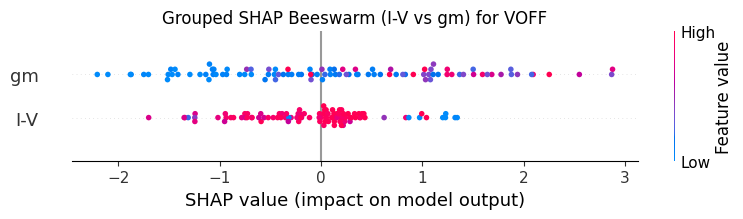

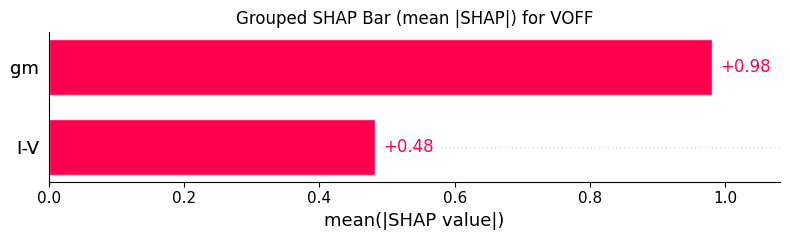

[Summary] I-V contribution (mean |SHAP|) = 4.8222e-01
[Summary] gm contribution  (mean |SHAP|) = 9.8006e-01
[Summary] gm/iv = 2.032


In [71]:
num_vgs = 6
pts_per_vds = 121
group_size = num_vgs * pts_per_vds 
n_groups = 2  # I-V, gm
group_names = ["I-V", "gm"]


voff_shap = param_contribute[0]
per_sample = np.array(voff_shap) 
samples_np = np.array(x_std[index_list[0]:index_list[1]]) 

n_samples, n_features = per_sample.shape
assert n_features == group_size * n_groups, f"feature count mismatch: {n_features} vs {group_size*n_groups}"

# reshape -> (n_samples, n_groups, group_size)
grouped_vals = per_sample.reshape(n_samples, n_groups, group_size).sum(axis=2)   # (n_samples, n_groups)
# 为了给 beeswarm 着色，我们需要每个 sample 每个 group 的“代表性原始值（feature value）”：
grouped_data = samples_np.reshape(n_samples, n_groups, group_size).mean(axis=2)  # (n_samples, n_groups)

# 构造 shap.Explanation
expl = shap.Explanation(values=grouped_vals, data=grouped_data, feature_names=group_names)

# Beeswarm (需要多个 sample 来展示分布)
try:
    shap.plots.beeswarm(expl, show=False)
    plt.title("Grouped SHAP Beeswarm (I-V vs gm) for VOFF")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("[Warning] beeswarm failed:", e)

# Bar plot (mean |SHAP|)
shap.plots.bar(expl, show=False)
plt.title("Grouped SHAP Bar (mean |SHAP|) for VOFF")
plt.tight_layout()
plt.show()

# 方便输出数值
iv_contrib = np.abs(grouped_vals[:,0]).mean()
gm_contrib = np.abs(grouped_vals[:,1]).mean()
print(f"[Summary] I-V contribution (mean |SHAP|) = {iv_contrib:.4e}")
print(f"[Summary] gm contribution  (mean |SHAP|) = {gm_contrib:.4e}")
print(f"[Summary] gm/iv = {gm_contrib/iv_contrib:.3f}")


